# Masinsko ucenje, 3. projekat
Sanja Milenkovic 1549

dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download

In [584]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from mlxtend.plotting import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from statistics import mean
from scipy.stats import uniform

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import recall_score

from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

In [585]:
dataset = pd.read_csv('heart.csv')
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [586]:
dataset.shape

(918, 12)

1. Priprema podataka

In [587]:
dataset.count()

Age               918
Sex               918
ChestPainType     918
RestingBP         918
Cholesterol       918
FastingBS         918
RestingECG        918
MaxHR             918
ExerciseAngina    918
Oldpeak           918
ST_Slope          918
HeartDisease      918
dtype: int64

In [588]:
dataset.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Zakljucak: nema praznih polja u datasetu

In [589]:
duplicates = dataset.duplicated()
print('Number of duplicates', duplicates.sum())

Number of duplicates 0


In [590]:
class_atribute = dataset['HeartDisease']

<Axes: xlabel='HeartDisease'>

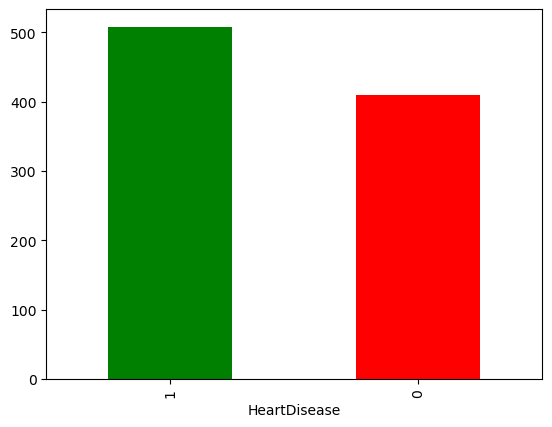

In [591]:
class_atribute.value_counts().plot(kind="bar", color=['green', 'red'])

In [592]:
dataset.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

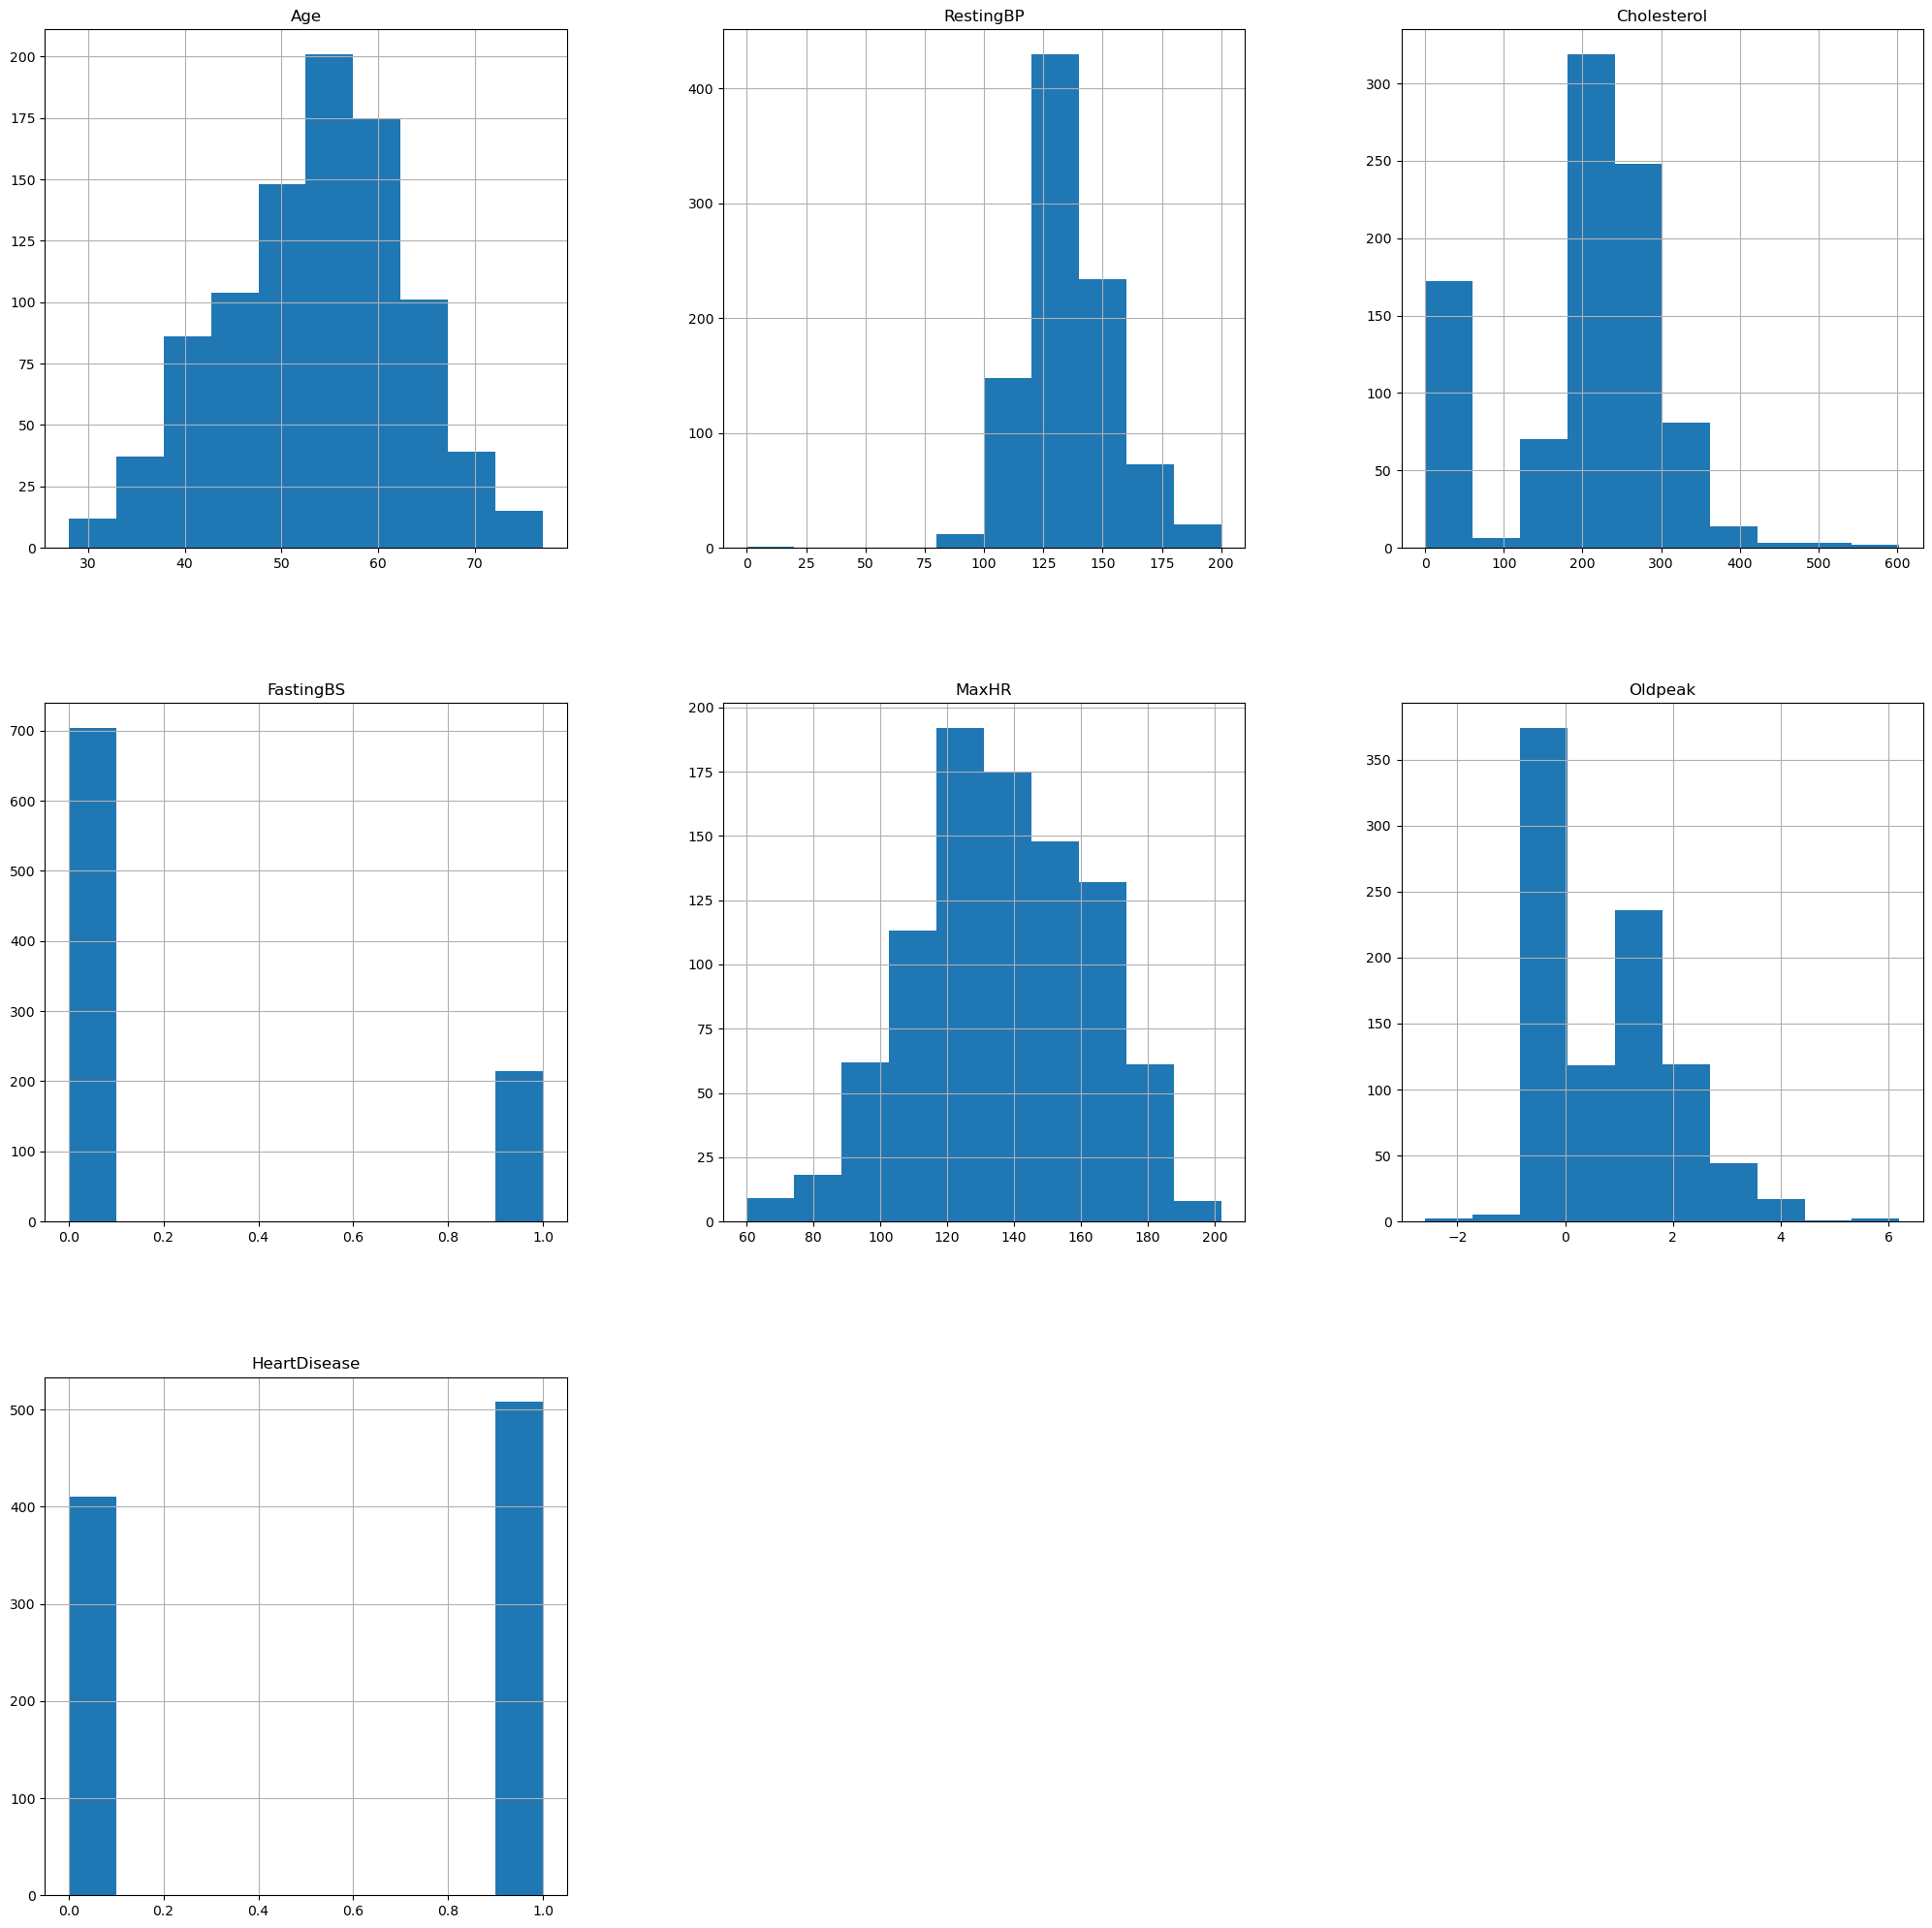

In [593]:
dataset.hist(figsize = (25,25))

In [594]:
label_encoder = preprocessing.LabelEncoder() 

dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
dataset['ChestPainType'] = label_encoder.fit_transform(dataset['ChestPainType'])
dataset['RestingECG'] = label_encoder.fit_transform(dataset['RestingECG'])
dataset['ExerciseAngina'] = label_encoder.fit_transform(dataset['ExerciseAngina'])
dataset['ST_Slope'] = label_encoder.fit_transform(dataset['ST_Slope'])

In [595]:
dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


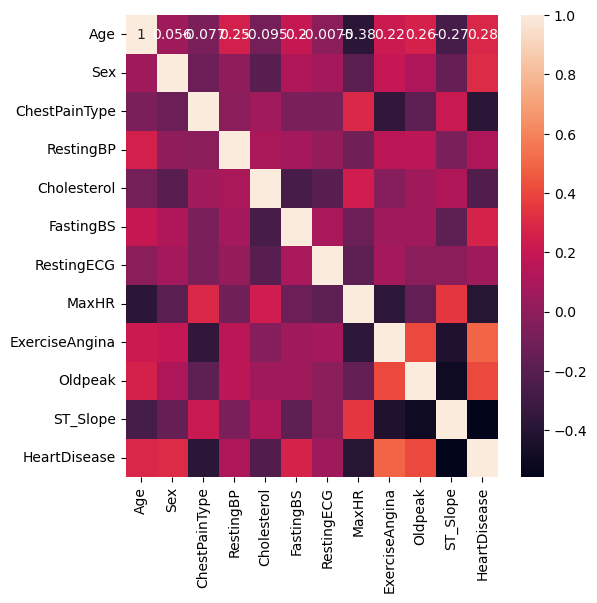

In [596]:
corr = dataset.corr()
plt.subplots(figsize=(6, 6))
sn.heatmap(corr, annot=True)
plt.show()

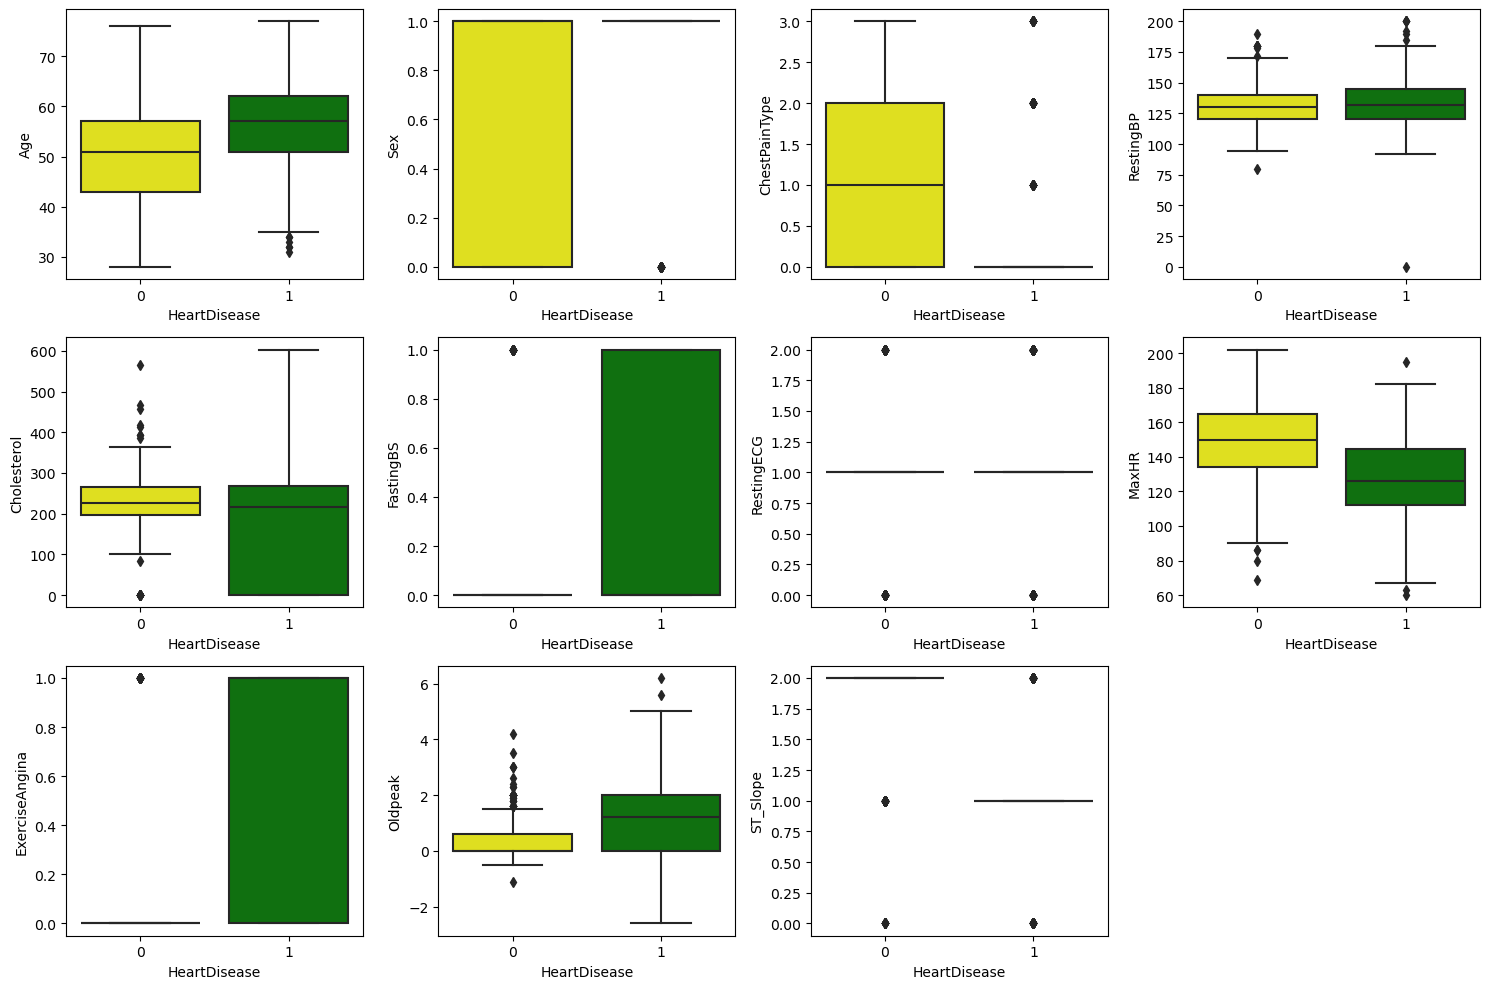

In [597]:
plt.figure(figsize=(15, 10))

num_cols = len(dataset.columns[:-1])
num_rows = (num_cols + 3) // 4  # Calculate number of rows dynamically

for i, column in enumerate(dataset.columns[:-1]):
    plt.subplot(num_rows, min(4, num_cols), i+1)  # Adjusting the number of columns per row
    sn.boxplot(x=dataset["HeartDisease"], y=dataset[column], palette=("yellow", "green"))
    plt.tight_layout()

plt.show()

In [598]:
def remove_outliers(dataset, column_names, th1=0.25, th3=0.75):
    dataset_no_outliers = dataset.copy()  # Make a copy of the dataset to avoid modifying the original

    for column_name in column_names:
        # Extract the specified feature
        feature = dataset_no_outliers[column_name]

        q11 = feature.quantile(th1)
        q33 = feature.quantile(th3)

        # Calculate quartiles and IQR
        iqr = q33 - q11
        lower_bound = q11 - (iqr * 1.5)
        upper_bound = q33 + (iqr * 1.5)

        # Identify outliers
        boolean_outliers = (feature > upper_bound) | (feature < lower_bound)

        # Remove outliers from the dataset
        dataset_no_outliers = dataset_no_outliers[~boolean_outliers]

    return dataset_no_outliers

In [599]:
def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 2 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 2 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

In [600]:
def scale_dataset(dataset): 
    sc = StandardScaler()
    dataset = sc.fit_transform(dataset)
    return dataset

In [601]:
def remove_ouliers_standard_deviation (dataset, column_names) :
    no_copy = dataset.copy()

    for column in column_names :
        lb, ub = determine_outlier_thresholds_std(dataset, column)
        outliers = (dataset[column] > ub) | (dataset[column] < lb)
        no_copy = no_copy[~outliers]

    return no_copy

In [602]:
dataset_std_outliers = remove_ouliers_standard_deviation(dataset, dataset.columns)
dataset_std_outliers

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
911,59,1,0,164,176,1,0,90,0,1.0,1,1
912,57,0,0,140,241,0,1,123,1,0.2,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


# Test and train data 

In [603]:
def split_test_and_train_data (dataset) : 

    x = dataset.drop('HeartDisease', axis=1).values
    y = dataset['HeartDisease'].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

    return x_train, x_test, y_train, y_test

In [604]:
def scale_test_and_train_data(x_train, x_test): 
    sc = StandardScaler()

    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)

    return x_train, x_test

In [605]:
x_train, x_test, y_train, y_test = split_test_and_train_data(dataset)
x_train, x_test = scale_test_and_train_data(x_train, x_test)

print('Num of train instances:', len(x_train))
print('Num of test instances:', len(x_test))

Num of train instances: 734
Num of test instances: 184


In [606]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = split_test_and_train_data(dataset_std_outliers)
x_train_scaled, x_test_scaled = scale_test_and_train_data(x_train_scaled, x_test_scaled)

print('Num of train instances:', len(x_train_scaled))
print('Num of test instances:', len(x_test_scaled))

Num of train instances: 570
Num of test instances: 143


In [607]:
unique_values, counts = np.unique(y_test_scaled, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[71 72]


In [608]:
unique_values, counts = np.unique(y_train_scaled, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[270 300]


Pomocne fje

In [609]:
def show_conf_matrix(y_pred):
  cm = confusion_matrix(y_test.astype(int), y_pred.astype(int))
  plt.figure()
  plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Reds)
  plt.xticks(range(2), ['NO', 'YES'], fontsize=16)
  plt.yticks(range(2), ['NO', 'YES'], fontsize=16)
  plt.show()

In [610]:
def show_hist(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [611]:
def get_pred_labels(ann, X_test):
  y_pred = ann.predict(X_test)
  for i in range(len(y_pred)):
    y_pred[i] = 1 if (y_pred[i] > 0.5) else 0
  y_pred = np.concatenate(y_pred, axis=0).astype(int)
  return y_pred

# #1 
- Adam optimizer
- Skalirani dataset

In [612]:
ann1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer
    tf.keras.layers.Dense(units=12, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann1.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [613]:
BATCH_SIZE = 32
EPOCHS = 50

ann1_history = ann1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann1_prediction = ann1.predict(x_test)

ann1_pred_labels = get_pred_labels(ann1, x_test)

Epoch 1/50
23/23 [==============================] - 2s 24ms/step - loss: 0.6128 - accuracy: 0.6853 - val_loss: 0.5258 - val_accuracy: 0.8098
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5553 - accuracy: 0.7575 - val_loss: 0.4692 - val_accuracy: 0.8478
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5106 - accuracy: 0.7875 - val_loss: 0.4289 - val_accuracy: 0.8696
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4783 - accuracy: 0.8011 - val_loss: 0.3983 - val_accuracy: 0.8696
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4556 - accuracy: 0.8147 - val_loss: 0.3805 - val_accuracy: 0.8750
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.4395 - accuracy: 0.8188 - val_loss: 0.3648 - val_accuracy: 0.8750
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.4274 - accuracy: 0.8188 - val_loss: 0.3552 - val_accuracy: 0.8750
Epoch 8/50
23/23 [=

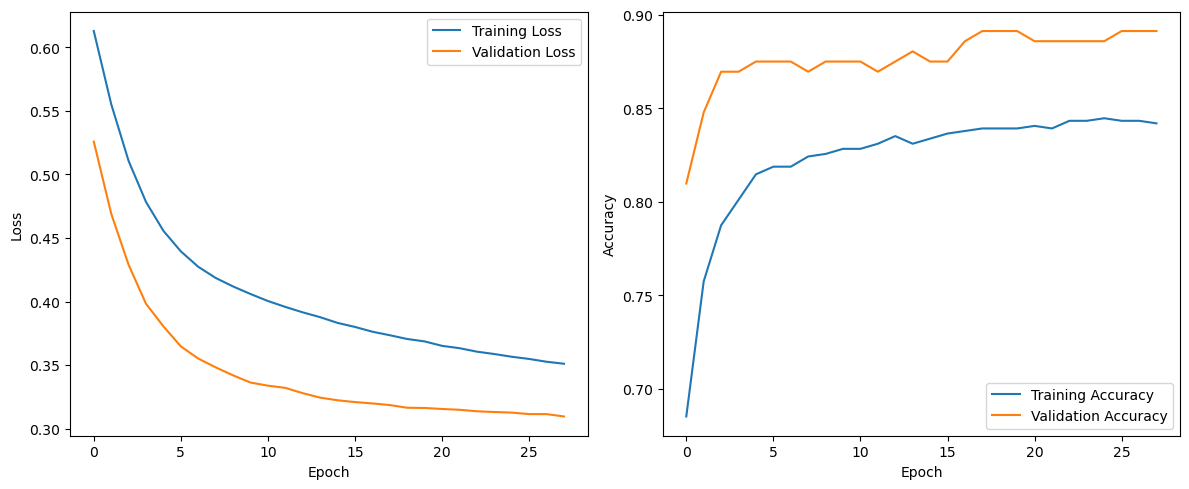

In [614]:
show_hist(ann1_history)

<Figure size 640x480 with 0 Axes>

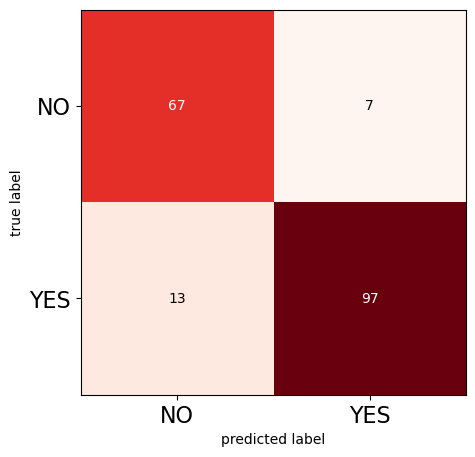

In [615]:
show_conf_matrix(ann1_pred_labels)

In [616]:
print(classification_report(y_test.astype(int), ann1_pred_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        74
           1       0.93      0.88      0.91       110

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



- Adam optimizer
- Skalirani dataset
- Izbaceni outlieri

In [617]:
BATCH_SIZE = 16
EPOCHS = 50

ann1_history_scaled = ann1.fit(x_train_scaled, y_train_scaled, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test_scaled, y_test_scaled))
ann1_prediction_scaled = ann1.predict(x_test_scaled)

ann1_pred_labels_scaled = get_pred_labels(ann1, x_test_scaled)

Epoch 1/50
36/36 [==============================] - 0s 8ms/step - loss: 0.2995 - accuracy: 0.8702 - val_loss: 0.4070 - val_accuracy: 0.8252
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2900 - accuracy: 0.8754 - val_loss: 0.4071 - val_accuracy: 0.8252
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2841 - accuracy: 0.8842 - val_loss: 0.4092 - val_accuracy: 0.8182
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2790 - accuracy: 0.8895 - val_loss: 0.4145 - val_accuracy: 0.8182
Epoch 5/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2746 - accuracy: 0.8895 - val_loss: 0.4161 - val_accuracy: 0.8182
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2719 - accuracy: 0.8930 - val_loss: 0.4196 - val_accuracy: 0.8182
Epoch 7/50
36/36 [==============================] - 0s 6ms/step - loss: 0.2684 - accuracy: 0.8930 - val_loss: 0.4242 - val_accuracy: 0.8112
Epoch 8/50
36/36 [==

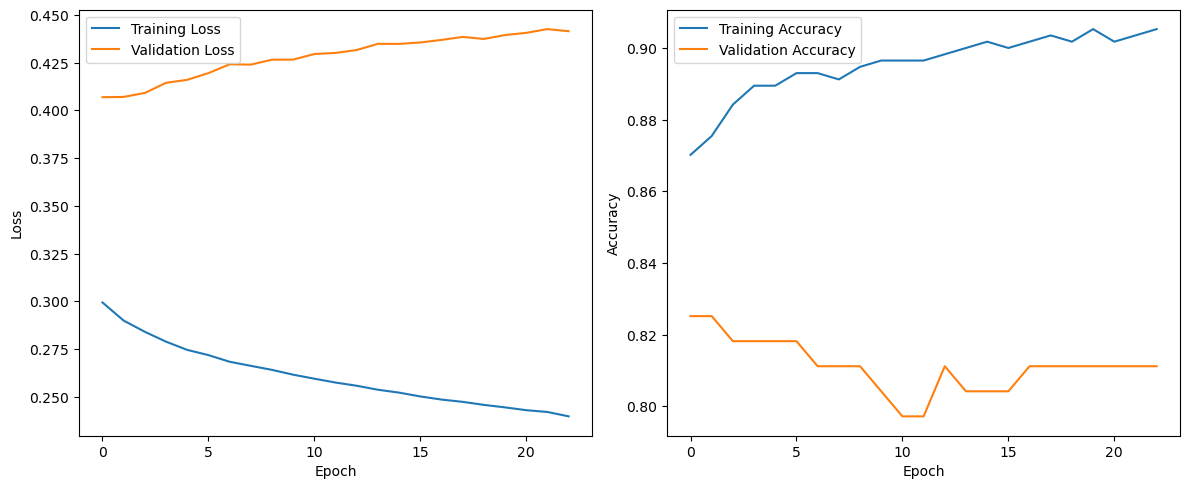

In [618]:
show_hist(ann1_history_scaled)

<Figure size 640x480 with 0 Axes>

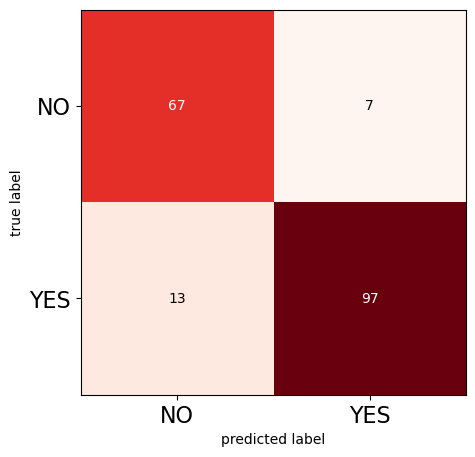

In [619]:
show_conf_matrix(ann1_pred_labels)

In [620]:
print(classification_report(y_test_scaled.astype(int), ann1_pred_labels_scaled.astype(int)))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        71
           1       0.79      0.85      0.82        72

    accuracy                           0.81       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.81      0.81      0.81       143



- Adagrad optimizer
- Skalirani dataset

In [621]:
ann1_adagrad_org = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer
    tf.keras.layers.Dense(units=12, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann1_adagrad_org.compile(optimizer='adagrad',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [622]:
BATCH_SIZE = 16
EPOCHS = 100

ann1_history_org_adagrad = ann1_adagrad_org.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann1_prediction_org_adagrad = ann1_adagrad_org.predict(x_test)

ann1_pred_labels_org_adagrad = get_pred_labels(ann1_adagrad_org, x_test)

Epoch 1/100
46/46 [==============================] - 2s 13ms/step - loss: 0.7249 - accuracy: 0.5477 - val_loss: 0.6776 - val_accuracy: 0.6033
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 0.7106 - accuracy: 0.5531 - val_loss: 0.6656 - val_accuracy: 0.6087
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5599 - val_loss: 0.6562 - val_accuracy: 0.6250
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5722 - val_loss: 0.6482 - val_accuracy: 0.6413
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5790 - val_loss: 0.6411 - val_accuracy: 0.6467
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5886 - val_loss: 0.6347 - val_accuracy: 0.6685
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.5940 - val_loss: 0.6288 - val_accuracy: 0.6848
Epoch 8/100


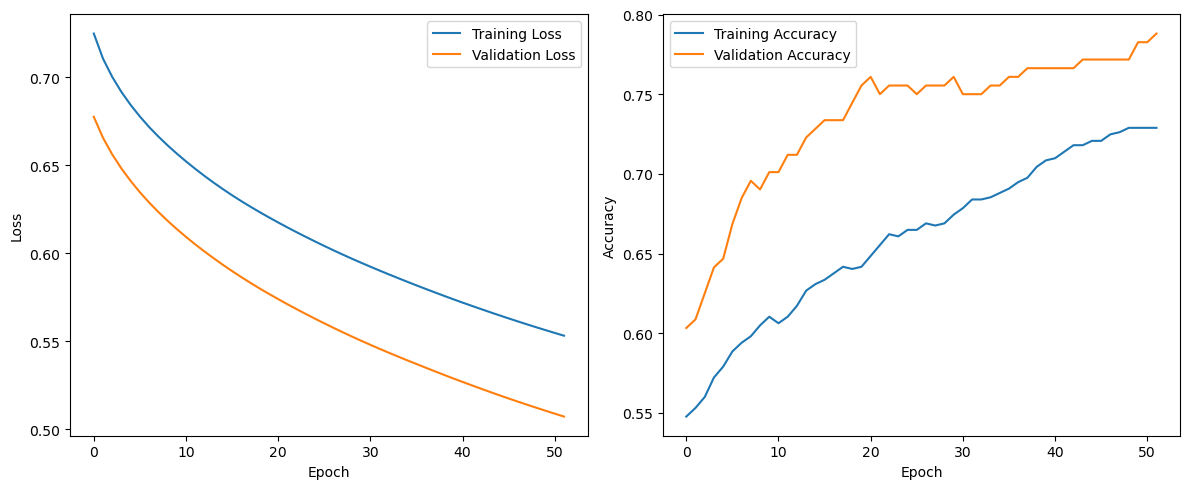

In [623]:
show_hist(ann1_history_org_adagrad)

<Figure size 640x480 with 0 Axes>

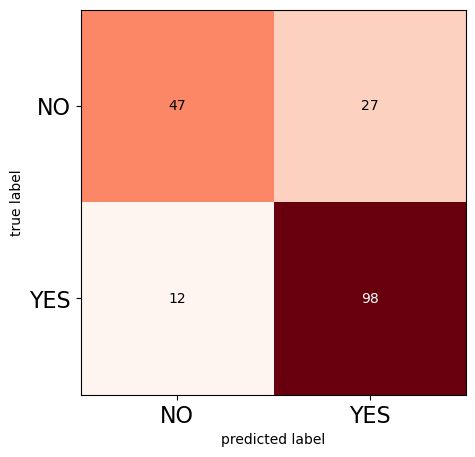

In [624]:
show_conf_matrix(ann1_pred_labels_org_adagrad)

In [625]:
print(classification_report(y_test.astype(int), ann1_pred_labels_org_adagrad.astype(int)))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71        74
           1       0.78      0.89      0.83       110

    accuracy                           0.79       184
   macro avg       0.79      0.76      0.77       184
weighted avg       0.79      0.79      0.78       184



- Adagrad optimizer
- Skalirani dataset
- Izbaceni outlieri

In [626]:
ann1_adagrad = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer
    tf.keras.layers.Dense(units=12, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann1_adagrad.compile(optimizer='adagrad',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [627]:
BATCH_SIZE = 32
EPOCHS = 50

ann1_history_scaled_adagrad = ann1_adagrad.fit(x_train_scaled, y_train_scaled, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test_scaled, y_test_scaled))
ann1_prediction_scaled_adagrad = ann1_adagrad.predict(x_test_scaled)

ann1_pred_labels_scaled_adagrad = get_pred_labels(ann1_adagrad, x_test_scaled)

Epoch 1/50
18/18 [==============================] - 2s 28ms/step - loss: 0.6326 - accuracy: 0.6474 - val_loss: 0.6451 - val_accuracy: 0.6364
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6266 - accuracy: 0.6596 - val_loss: 0.6407 - val_accuracy: 0.6364
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6216 - accuracy: 0.6649 - val_loss: 0.6368 - val_accuracy: 0.6434
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6171 - accuracy: 0.6754 - val_loss: 0.6334 - val_accuracy: 0.6643
Epoch 5/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6131 - accuracy: 0.6807 - val_loss: 0.6304 - val_accuracy: 0.6713
Epoch 6/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6094 - accuracy: 0.6877 - val_loss: 0.6275 - val_accuracy: 0.6853
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6059 - accuracy: 0.6912 - val_loss: 0.6249 - val_accuracy: 0.6923
Epoch 8/50
18/18 [=

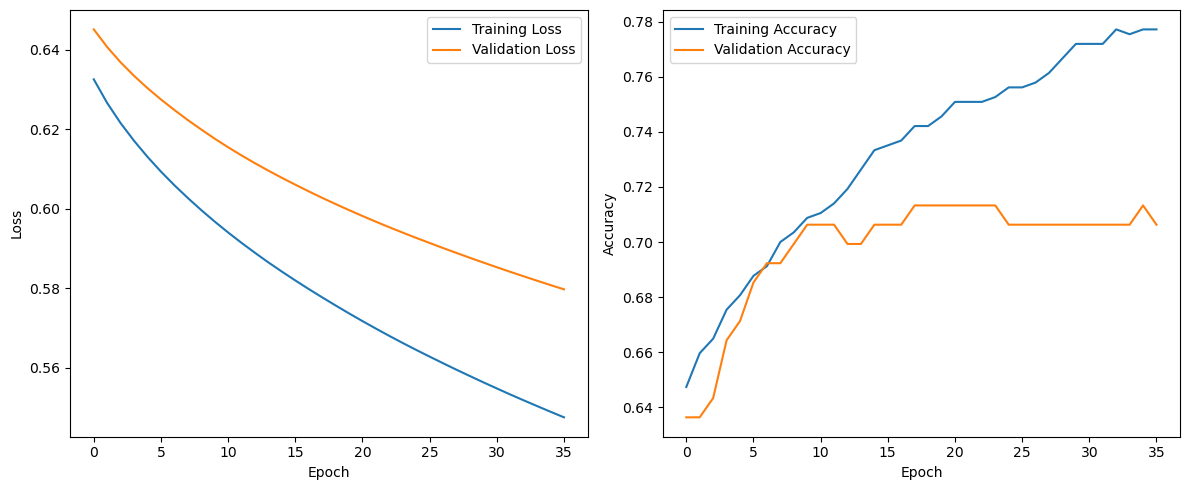

In [628]:
show_hist(ann1_history_scaled_adagrad)

<Axes: >

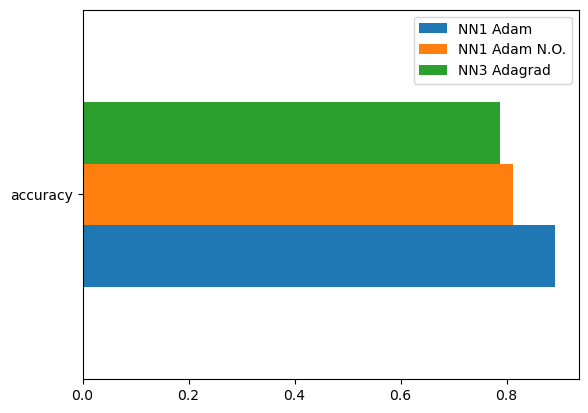

In [629]:
acc1 = accuracy_score(y_test.astype(int), ann1_pred_labels.astype(int))
acc1_scaled = accuracy_score(y_test_scaled.astype(int), ann1_pred_labels_scaled.astype(int))
acc1_adagrad = accuracy_score(y_test.astype(int), ann1_pred_labels_org_adagrad.astype(int))

model_scores = {
    'NN1 Adam': acc1,
    'NN1 Adam N.O.': acc1_scaled,
    'NN3 Adagrad': acc1_adagrad
}
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.plot(kind='barh',)

# #2
- Skaliran dataset
- Adam optimizer

In [630]:
ann2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer and 1st Hidden layer
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=8, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
     tf.keras.layers.Dense(units=4, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann2.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [631]:
BATCH_SIZE = 64
EPOCHS = 100

ann2_history = ann2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann2_prediction = ann2.predict(x_test)

ann2_pred_labels = get_pred_labels(ann2, x_test)

Epoch 1/100
12/12 [==============================] - 3s 57ms/step - loss: 0.6911 - accuracy: 0.5804 - val_loss: 0.6782 - val_accuracy: 0.6141
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6889 - accuracy: 0.5954 - val_loss: 0.6625 - val_accuracy: 0.6413
Epoch 3/100
12/12 [==============================] - 0s 12ms/step - loss: 0.6647 - accuracy: 0.6458 - val_loss: 0.6459 - val_accuracy: 0.6793
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6571 - accuracy: 0.6362 - val_loss: 0.6293 - val_accuracy: 0.7120
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6477 - accuracy: 0.6580 - val_loss: 0.6126 - val_accuracy: 0.7337
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 0.6326 - accuracy: 0.6703 - val_loss: 0.5932 - val_accuracy: 0.7609
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6126 - accuracy: 0.6894 - val_loss: 0.5704 - val_accuracy: 0.7772
Epoch 8

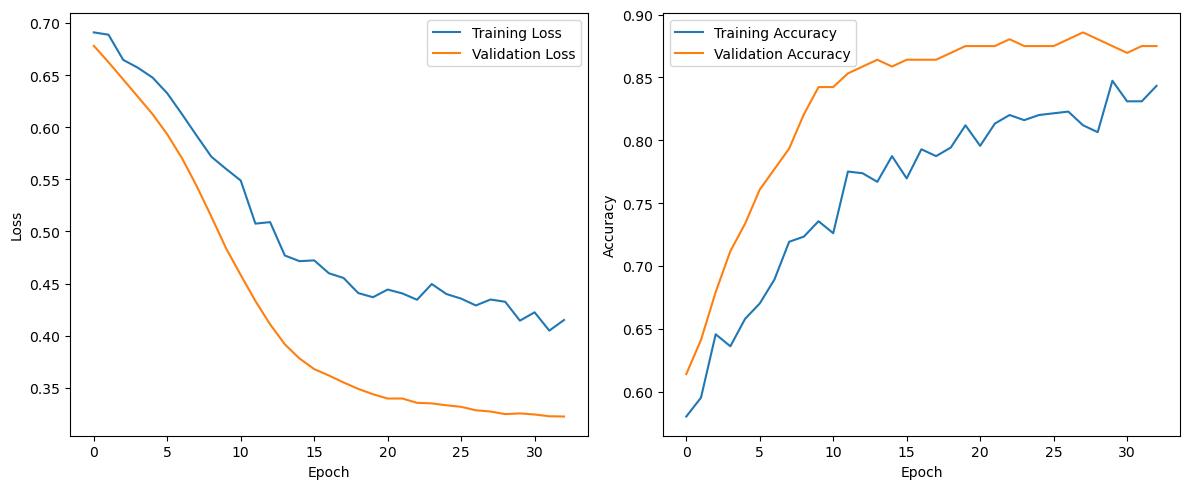

In [632]:
show_hist(ann2_history)

<Figure size 640x480 with 0 Axes>

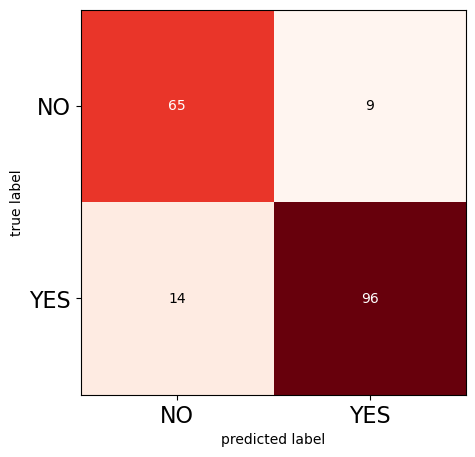

In [633]:
show_conf_matrix(ann2_pred_labels)

In [634]:
print(classification_report(y_test.astype(int), ann2_pred_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        74
           1       0.91      0.87      0.89       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



- Skalirani dataset
- Izbaceni outlieri

In [635]:
BATCH_SIZE = 32
EPOCHS = 100

ann2_history_scaled = ann2.fit(x_train_scaled, y_train_scaled, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test_scaled, y_test_scaled))
ann2_prediction_scaled = ann2.predict(x_test_scaled)

ann2_pred_labels_scaled = get_pred_labels(ann2, x_test_scaled)

Epoch 1/100
18/18 [==============================] - 0s 27ms/step - loss: 0.3846 - accuracy: 0.8579 - val_loss: 0.3866 - val_accuracy: 0.8462
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.3681 - accuracy: 0.8684 - val_loss: 0.3839 - val_accuracy: 0.8462
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3633 - accuracy: 0.8632 - val_loss: 0.3824 - val_accuracy: 0.8531
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3650 - accuracy: 0.8614 - val_loss: 0.3844 - val_accuracy: 0.8462
Epoch 5/100
5/5 [==============================] - 0s 2ms/step


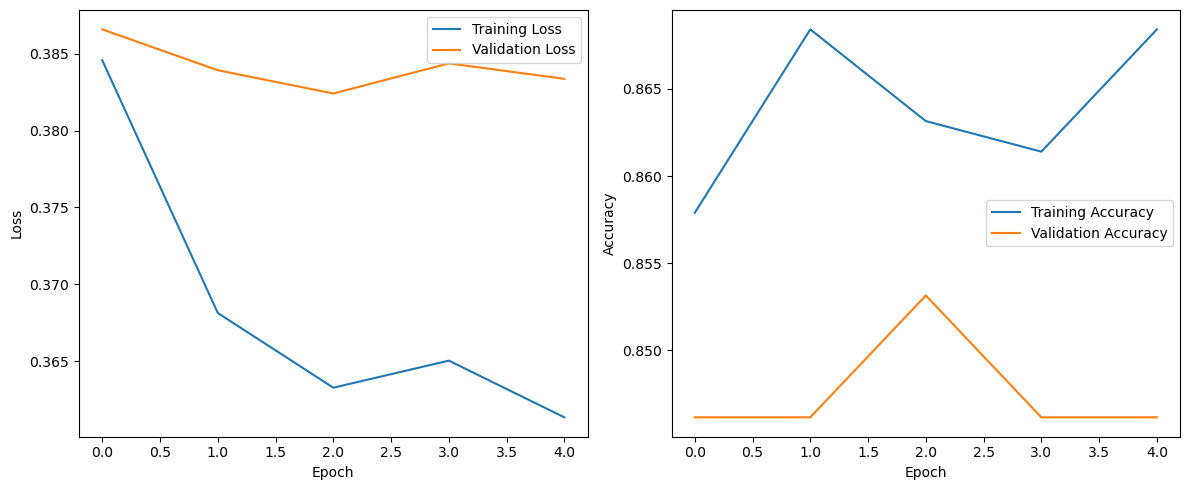

In [636]:
show_hist(ann2_history_scaled)

In [637]:
print(classification_report(y_test_scaled.astype(int), ann2_pred_labels_scaled.astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        71
           1       0.82      0.89      0.85        72

    accuracy                           0.85       143
   macro avg       0.85      0.85      0.85       143
weighted avg       0.85      0.85      0.85       143



- Adagrad optimizer
- Skalirani dataset

In [638]:
ann2_adagrad = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer and 1st Hidden layer
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=8, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
     tf.keras.layers.Dense(units=4, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann2_adagrad.compile(optimizer='adagrad',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [639]:
BATCH_SIZE = 32
EPOCHS = 100

ann2_history_adagrad = ann2_adagrad.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann2_prediction_adagrad = ann2_adagrad.predict(x_test)

ann2_pred_labels_adagrad = get_pred_labels(ann2_adagrad, x_test)

Epoch 1/100
23/23 [==============================] - 2s 33ms/step - loss: 0.6946 - accuracy: 0.5163 - val_loss: 0.6855 - val_accuracy: 0.5489
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.5313 - val_loss: 0.6831 - val_accuracy: 0.5435
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 0.6833 - accuracy: 0.5599 - val_loss: 0.6809 - val_accuracy: 0.5652
Epoch 4/100
23/23 [==============================] - 0s 10ms/step - loss: 0.6785 - accuracy: 0.5599 - val_loss: 0.6788 - val_accuracy: 0.5761
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 0.6786 - accuracy: 0.5681 - val_loss: 0.6770 - val_accuracy: 0.5978
Epoch 6/100
23/23 [==============================] - 0s 9ms/step - loss: 0.6754 - accuracy: 0.5926 - val_loss: 0.6751 - val_accuracy: 0.6087
Epoch 7/100
23/23 [==============================] - 0s 12ms/step - loss: 0.6740 - accuracy: 0.5763 - val_loss: 0.6733 - val_accuracy: 0.6250
Epoch 8

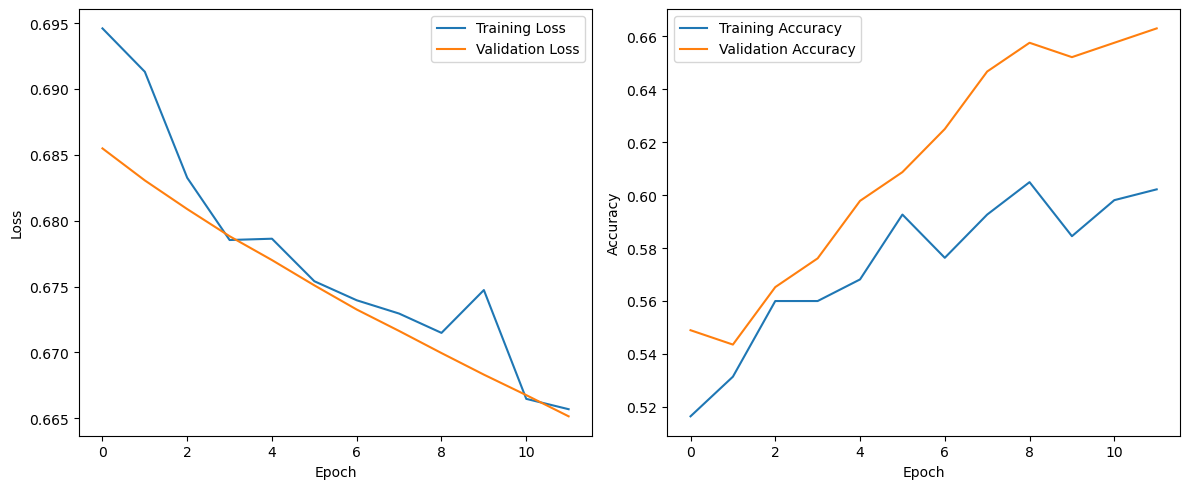

In [640]:
show_hist(ann2_history_adagrad)

In [641]:
print(classification_report(y_test.astype(int), ann2_pred_labels_adagrad.astype(int)))

              precision    recall  f1-score   support

           0       0.55      0.82      0.66        74
           1       0.82      0.55      0.66       110

    accuracy                           0.66       184
   macro avg       0.69      0.69      0.66       184
weighted avg       0.72      0.66      0.66       184



<Axes: >

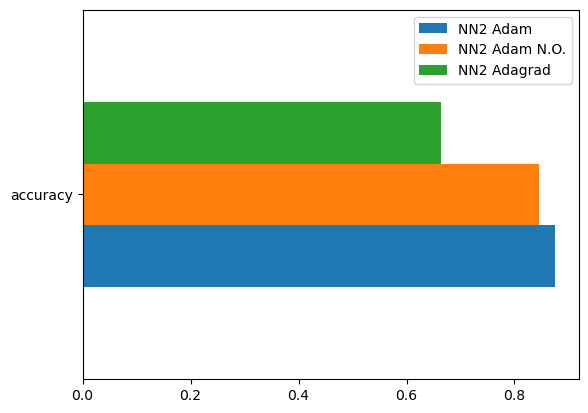

In [646]:
acc2 = accuracy_score(y_test.astype(int), ann2_pred_labels.astype(int))
acc2_scaled = accuracy_score(y_test_scaled.astype(int), ann2_pred_labels_scaled.astype(int))
acc2_adagrad = accuracy_score(y_test.astype(int), ann2_pred_labels_adagrad.astype(int))

model_scores = {
    'NN2 Adam': acc2,
    'NN2 Adam N.O.': acc2_scaled,
    'NN2 Adagrad': acc2_adagrad
}
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.plot(kind='barh',)

In [642]:
ann_overfitted = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer and 1st Hidden layer
    tf.keras.layers.Dense(units=30, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dense(units=40, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dense(units=20, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann_overfitted.compile(optimizer='adam',
            loss=tf.keras.losses.MeanAbsoluteError(),
            metrics=['accuracy'])


In [643]:
BATCH_SIZE = 64
EPOCHS = 100

ann_history_overfitted = ann_overfitted.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/100
12/12 [==============================] - 2s 45ms/step - loss: 0.4840 - accuracy: 0.6894 - val_loss: 0.4521 - val_accuracy: 0.8261
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.4393 - accuracy: 0.7970 - val_loss: 0.3975 - val_accuracy: 0.8424
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.3842 - accuracy: 0.8106 - val_loss: 0.3260 - val_accuracy: 0.8478
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.3124 - accuracy: 0.8134 - val_loss: 0.2495 - val_accuracy: 0.8478
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.2460 - accuracy: 0.8202 - val_loss: 0.1935 - val_accuracy: 0.8478
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.2064 - accuracy: 0.8256 - val_loss: 0.1604 - val_accuracy: 0.8696
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1854 - accuracy: 0.8447 - val_loss: 0.1409 - val_accuracy: 0.8859
Epoch 8/100


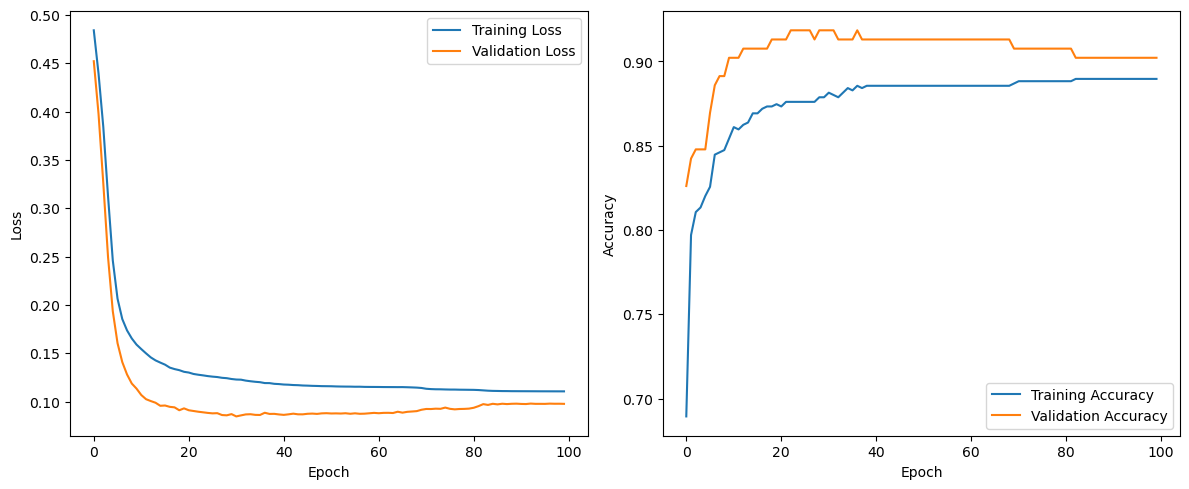

In [644]:
show_hist(ann_history_overfitted)

# #1 i #2 sa custom loss funkcijom

In [662]:
import tensorflow.keras.backend as kb

class customLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):        
        log_y_pred = tf.math.log(y_pred)
        elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        return tf.reduce_mean(tf.reduce_sum(elements,axis=1))

def self_loss_function(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    custom_loss=kb.square(y_true-y_pred)
    return custom_loss
    

In [663]:
ann1_custom_loss = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer
    tf.keras.layers.Dense(units=12, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

ann1_custom_loss.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                  patience=3)

In [664]:
BATCH_SIZE = 32
EPOCHS = 100

ann1_hist_customloss = ann1_custom_loss.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann1_prediction_customloss = ann1_custom_loss.predict(x_test)

ann1_pred_labels_customloss = get_pred_labels(ann1_custom_loss, x_test)

Epoch 1/100
23/23 [==============================] - 2s 23ms/step - loss: 0.7049 - accuracy: 0.5368 - val_loss: 0.6411 - val_accuracy: 0.6739
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6360 - accuracy: 0.6621 - val_loss: 0.5840 - val_accuracy: 0.7826
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5882 - accuracy: 0.7507 - val_loss: 0.5374 - val_accuracy: 0.8043
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5464 - accuracy: 0.7779 - val_loss: 0.4890 - val_accuracy: 0.8207
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5035 - accuracy: 0.8011 - val_loss: 0.4449 - val_accuracy: 0.8370
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4658 - accuracy: 0.8120 - val_loss: 0.4059 - val_accuracy: 0.8424
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4372 - accuracy: 0.8065 - val_loss: 0.3785 - val_accuracy: 0.8641
Epoch 8/100


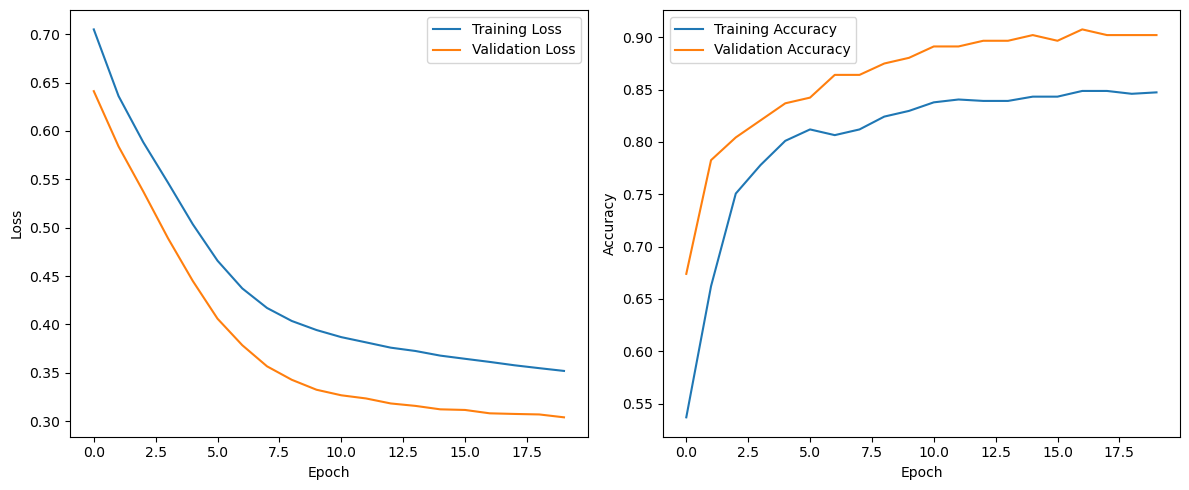

In [665]:
show_hist(ann1_hist_customloss)

<Figure size 640x480 with 0 Axes>

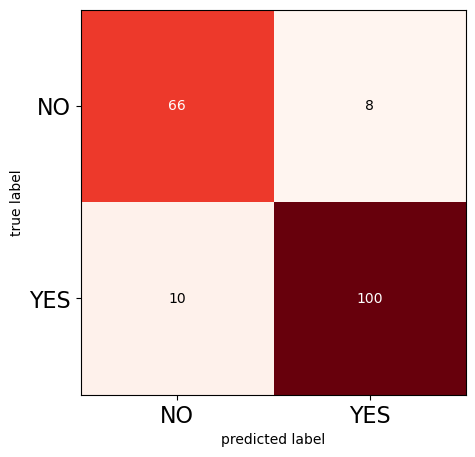

In [666]:
show_conf_matrix(ann1_pred_labels_customloss)

In [667]:
ann3_custom_loss = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=12, activation='relu'), # Input layer and 1st Hidden layer
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=8, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
     tf.keras.layers.Dense(units=4, activation='relu'), # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.Dense(units=1, activation='sigmoid') # Output layer
])

In [668]:
ann3_custom_loss.compile(optimizer='adam',
            loss=self_loss_function,
            metrics=['accuracy'])

In [669]:
BATCH_SIZE = 32
EPOCHS = 100

ann3_hist_customloss = ann3_custom_loss.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping], validation_data=(x_test, y_test))
ann3_prediction_customloss = ann3_custom_loss.predict(x_test)

ann3_pred_labels_customloss = get_pred_labels(ann3_custom_loss, x_test)

Epoch 1/100
23/23 [==============================] - 2s 23ms/step - loss: 0.2840 - accuracy: 0.4918 - val_loss: 0.2714 - val_accuracy: 0.4402
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2560 - accuracy: 0.5368 - val_loss: 0.2303 - val_accuracy: 0.6739
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2291 - accuracy: 0.6621 - val_loss: 0.2056 - val_accuracy: 0.7772
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2155 - accuracy: 0.6894 - val_loss: 0.1841 - val_accuracy: 0.8261
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1953 - accuracy: 0.7452 - val_loss: 0.1662 - val_accuracy: 0.8533
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1823 - accuracy: 0.7684 - val_loss: 0.1508 - val_accuracy: 0.8587
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.1830 - accuracy: 0.7561 - val_loss: 0.1377 - val_accuracy: 0.8750
Epoch 8/100


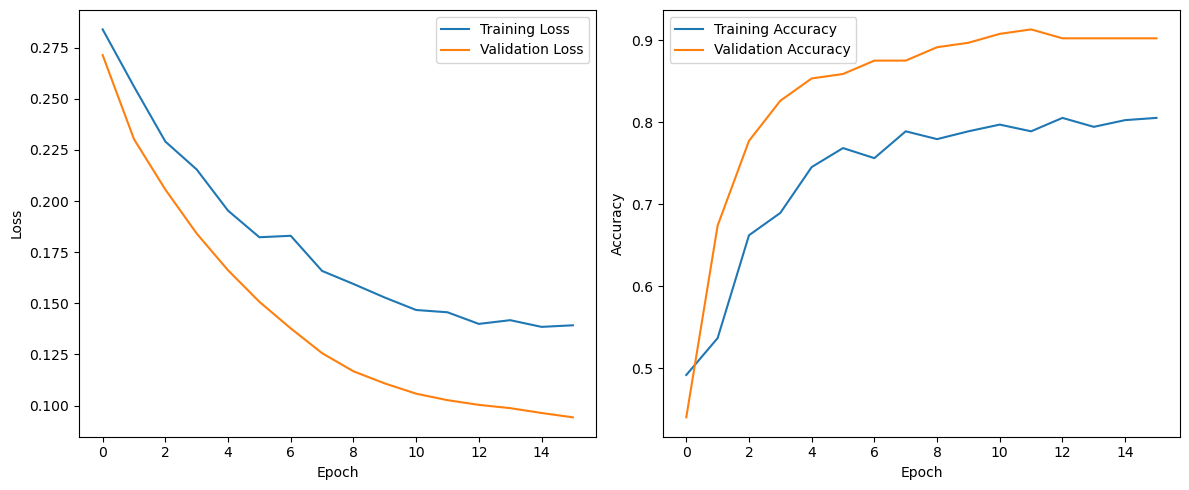

In [670]:
show_hist(ann3_hist_customloss)

<Figure size 640x480 with 0 Axes>

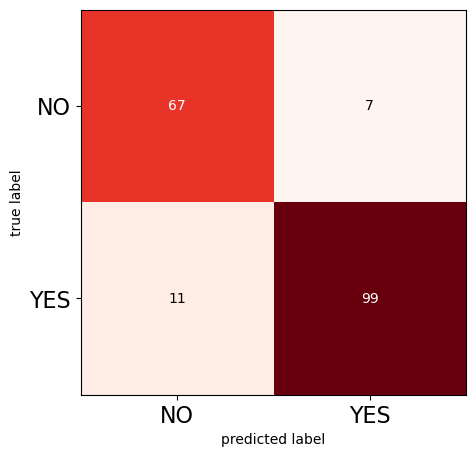

In [671]:
show_conf_matrix(ann3_pred_labels_customloss)

<Axes: >

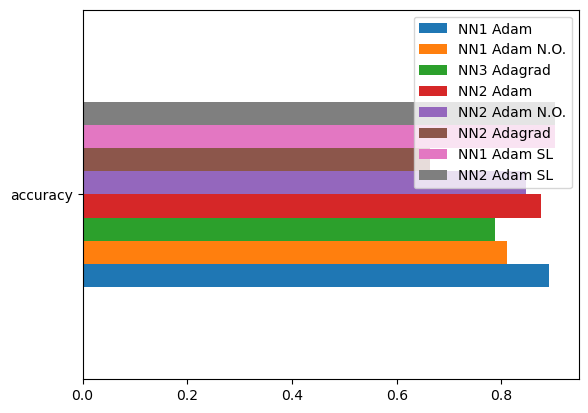

In [675]:
acc1 = accuracy_score(y_test.astype(int), ann1_pred_labels.astype(int))
acc1_scaled = accuracy_score(y_test_scaled.astype(int), ann1_pred_labels_scaled.astype(int))
acc1_adagrad = accuracy_score(y_test.astype(int), ann1_pred_labels_org_adagrad.astype(int))

acc2 = accuracy_score(y_test.astype(int), ann2_pred_labels.astype(int))
acc2_scaled = accuracy_score(y_test_scaled.astype(int), ann2_pred_labels_scaled.astype(int))
acc2_adagrad = accuracy_score(y_test.astype(int), ann2_pred_labels_adagrad.astype(int))

acc1_selfloss = accuracy_score(y_test.astype(int), ann1_pred_labels_customloss.astype(int))
acc3_selfloss = accuracy_score(y_test.astype(int), ann3_pred_labels_customloss.astype(int))


model_scores = {
    'NN1 Adam': acc1,
    'NN1 Adam N.O.': acc1_scaled,
    'NN3 Adagrad': acc1_adagrad,
    'NN2 Adam': acc2,
    'NN2 Adam N.O.': acc2_scaled,
    'NN2 Adagrad': acc2_adagrad,
    'NN1 Adam SL': acc1_selfloss,
    'NN2 Adam SL': acc3_selfloss
}
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.plot(kind='barh',)